Initialising the spark and using spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/01/24 10:39:30 WARN Utils: Your hostname, pavanlinux resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
22/01/24 10:39:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/24 10:39:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Getting the data from the url which contains the stock market data and writing it into the csv file

In [3]:
import csv
import requests

CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=15min&slice=year1month1&apikey=4KRSSGN8IWNU8IBV'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    csv_file= open('/home/pavan-linux/Stock_Project/data.csv', 'w')
    csv_writer = csv.writer(csv_file, delimiter=",")
    for row in my_list:
        csv_writer.writerow(row)

In [ ]:
df=spark.read.csv("/home/pavan-linux/Stock_Project/data.csv",header=True,inferSchema=True)

Reading the csv file and spliting tha data using split function 

In [ ]:
def split(x):
    temp=x.split()
    return temp[0]

from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType

new_split = udf(lambda x:split(x),StringType())

In [ ]:
from pyspark.sql.functions import lower, col
df = df.withColumn("Date",new_split(col("time")))

In [ ]:
df.createOrReplaceTempView("table")

In [ ]:
df=spark.sql("SELECT Date,FIRST(open) as open,MAX(high) as high,MIN(low) as low,LAST(close) as close,MAX(volume) as volume from table GROUP BY Date ORDER BY Date")

In [ ]:
df.show()

+----------+------+--------+--------+------+-------+
|      Date|  open|    high|     low| close| volume|
+----------+------+--------+--------+------+-------+
|2021-12-27|131.35|  131.65|  129.95|130.95| 418362|
|2021-12-28|132.95|  133.22|  131.55| 131.7| 363077|
|2021-12-29| 133.0|  134.21|   132.3|132.44| 342721|
|2021-12-30|133.83|  134.37|  133.02|133.41| 446147|
|2021-12-31|133.69|  134.99|  133.46|133.88| 436471|
|2022-01-03|135.77| 136.295|  133.61| 133.8| 420316|
|2022-01-04| 137.8|  139.95|   135.9|136.41| 581760|
|2022-01-05|138.09|   142.2|  137.25|137.96| 999384|
|2022-01-06|135.45|138.4099|  132.51| 137.6| 932284|
|2022-01-07|134.83|135.6618|133.5111|135.07| 638345|
|2022-01-10|135.03|   136.2|  133.38| 135.1| 563951|
|2022-01-11| 132.8|  133.72|  127.97| 132.9|2168991|
|2022-01-12| 133.4|  134.47|  131.37| 132.7| 497902|
|2022-01-13| 134.6|  136.05| 133.377|133.66| 581846|
|2022-01-14|134.22|  135.14|   133.3|134.54| 468711|
|2022-01-18|132.71|   134.0|  131.78|133.37| 5

In [ ]:
from pyspark.sql.functions import lead,col
from pyspark.sql.window import Window

In [ ]:
window=Window.orderBy("Date")

In [ ]:
a= lead(col("open")).over(window)

In [ ]:
final_df = df.withColumn("next_open",a).dropna(how="any")

In [ ]:
final_df.show()

22/01/24 10:28:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+------+--------+--------+------+-------+---------+
|      Date|  open|    high|     low| close| volume|next_open|
+----------+------+--------+--------+------+-------+---------+
|2021-12-27|131.35|  131.65|  129.95|130.95| 418362|   132.95|
|2021-12-28|132.95|  133.22|  131.55| 131.7| 363077|    133.0|
|2021-12-29| 133.0|  134.21|   132.3|132.44| 342721|   133.83|
|2021-12-30|133.83|  134.37|  133.02|133.41| 446147|   133.69|
|2021-12-31|133.69|  134.99|  133.46|133.88| 436471|   135.77|
|2022-01-03|135.77| 136.295|  133.61| 133.8| 420316|    137.8|
|2022-01-04| 137.8|  139.95|   135.9|136.41| 581760|   138.09|
|2022-01-05|138.09|   142.2|  137.25|137.96| 999384|   135.45|
|2022-01-06|135.45|138.4099|  132.51| 137.6| 932284|   134.83|
|2022-01-07|134.83|135.6618|133.5111|135.07| 638345|   135.03|
|2022-01-10|135.03|   136.2|  133.38| 135.1| 563951|    132.8|
|2022-01-11| 132.8|  133.72|  127.97| 132.9|2168991|    133.4|
|2022-01-12| 133.4|  134.47|  131.37| 132.7| 497902|   

In [ ]:
import numpy as np
import pandas as pd                   
import matplotlib.pyplot as plt       
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

Getting all the data in features

In [ ]:
feature = VectorAssembler(inputCols=['open','high','low','close','volume'],outputCol='features')

In [ ]:
final_data  = feature.transform(final_df)

In [ ]:
final_data.show()

22/01/24 10:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+------+--------+--------+------+-------+---------+--------------------+
|      Date|  open|    high|     low| close| volume|next_open|            features|
+----------+------+--------+--------+------+-------+---------+--------------------+
|2021-12-27|131.35|  131.65|  129.95|130.95| 418362|   132.95|[131.35,131.65,12...|
|2021-12-28|132.95|  133.22|  131.55| 131.7| 363077|    133.0|[132.95,133.22,13...|
|2021-12-29| 133.0|  134.21|   132.3|132.44| 342721|   133.83|[133.0,134.21,132...|
|2021-12-30|133.83|  134.37|  133.02|133.41| 446147|   133.69|[133.83,134.37,13...|
|2021-12-31|133.69|  134.99|  133.46|133.88| 436471|   135.77|[133.69,134.99,13...|
|2022-01-03|135.77| 136.295|  133.61| 133.8| 420316|    137.8|[135.77,136.295,1...|
|2022-01-04| 137.8|  139.95|   135.9|136.41| 581760|   138.09|[137.8,139.95,135...|
|2022-01-05|138.09|   142.2|  137.25|137.96| 999384|   135.45|[138.09,142.2,137...|
|2022-01-06|135.45|138.4099|  132.51| 137.6| 932284|   134.83|[135.45,138.40

Taking featuers and next_open for the prediction

In [ ]:
final_data = final_data.select('features','next_open')
final_data.show()

22/01/24 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+---------+
|            features|next_open|
+--------------------+---------+
|[131.35,131.65,12...|   132.95|
|[132.95,133.22,13...|    133.0|
|[133.0,134.21,132...|   133.83|
|[133.83,134.37,13...|   133.69|
|[133.69,134.99,13...|   135.77|
|[135.77,136.295,1...|    137.8|
|[137.8,139.95,135...|   138.09|
|[138.09,142.2,137...|   135.45|
|[135.45,138.4099,...|   134.83|
|[134.83,135.6618,...|   135.03|
|[135.03,136.2,133...|    132.8|
|[132.8,133.72,127...|    133.4|
|[133.4,134.47,131...|    134.6|
|[134.6,136.05,133...|   134.22|
|[134.22,135.14,13...|   132.71|
|[132.71,134.0,131...|   131.01|
|[131.01,133.9,131...|   130.79|
|[130.79,132.88,13...|    129.3|
+--------------------+---------+



In [ ]:
train,test = final_data.randomSplit([0.6,0.4])

In [ ]:
regressor = LinearRegression(featuresCol = 'features', labelCol = 'next_open')
regressor = regressor.fit(train)

In [ ]:
predictions = regressor.transform(test)
predictions.show()

22/01/24 10:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+---------+------------------+
|            features|next_open|        prediction|
+--------------------+---------+------------------+
|[130.79,132.88,13...|    129.3|129.59846976941813|
|[132.8,133.72,127...|    133.4| 136.1646398308993|
|[133.0,134.21,132...|   133.83| 132.2698780466366|
|[133.4,134.47,131...|    134.6|136.54267805665478|
|[133.69,134.99,13...|   135.77| 130.9338398958632|
|[133.83,134.37,13...|   133.69|132.02791717669948|
|[134.22,135.14,13...|   132.71|133.55557026599348|
|[135.03,136.2,133...|    132.8| 136.4949328815348|
|[135.45,138.4099,...|   134.83|142.83473552467393|
|[137.8,139.95,135...|   138.09|139.41585681874457|
+--------------------+---------+------------------+



In [ ]:
regressor.coefficients

DenseVector([2.9421, 1.0497, -3.9748, 0.7434, -0.0])

In [ ]:
regressor.intercept

29.86037250643099

In [ ]:
results=regressor.evaluate(test)

22/01/24 10:28:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
print("Root Mean Squared Error (RMSE) on test data = %g" % results.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 3.46832


In [ ]:
panda_df = predictions.toPandas()

22/01/24 10:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


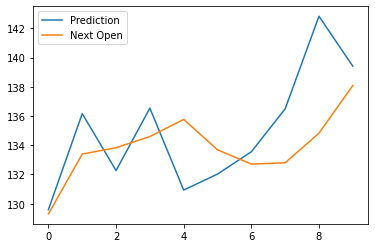

In [ ]:
plt.plot(panda_df['prediction'])
plt.plot(panda_df['next_open'])
plt.legend(['Prediction','Next Open'])